Running 50 simulations for each distribution and budget...
  ...run 10/50
  ...run 20/50
  ...run 30/50
  ...run 40/50
  ...run 50/50

--- Average Mean Squared Error vs. Budget ---

--- Distribution: pythia69 ---
       Uniform  Thompson  Baharav et al. (Alg 1)
5     0.297469  0.298360                0.213254
10    0.267292  0.270800                0.198962
100   0.125271  0.044198                0.125270
500   0.058297  0.011053                0.058286
1000  0.042898  0.017701                0.042855
2500  0.031611  0.021973                0.031515
5000  0.025142  0.020981                0.024977
7500  0.021031  0.018414                0.020811


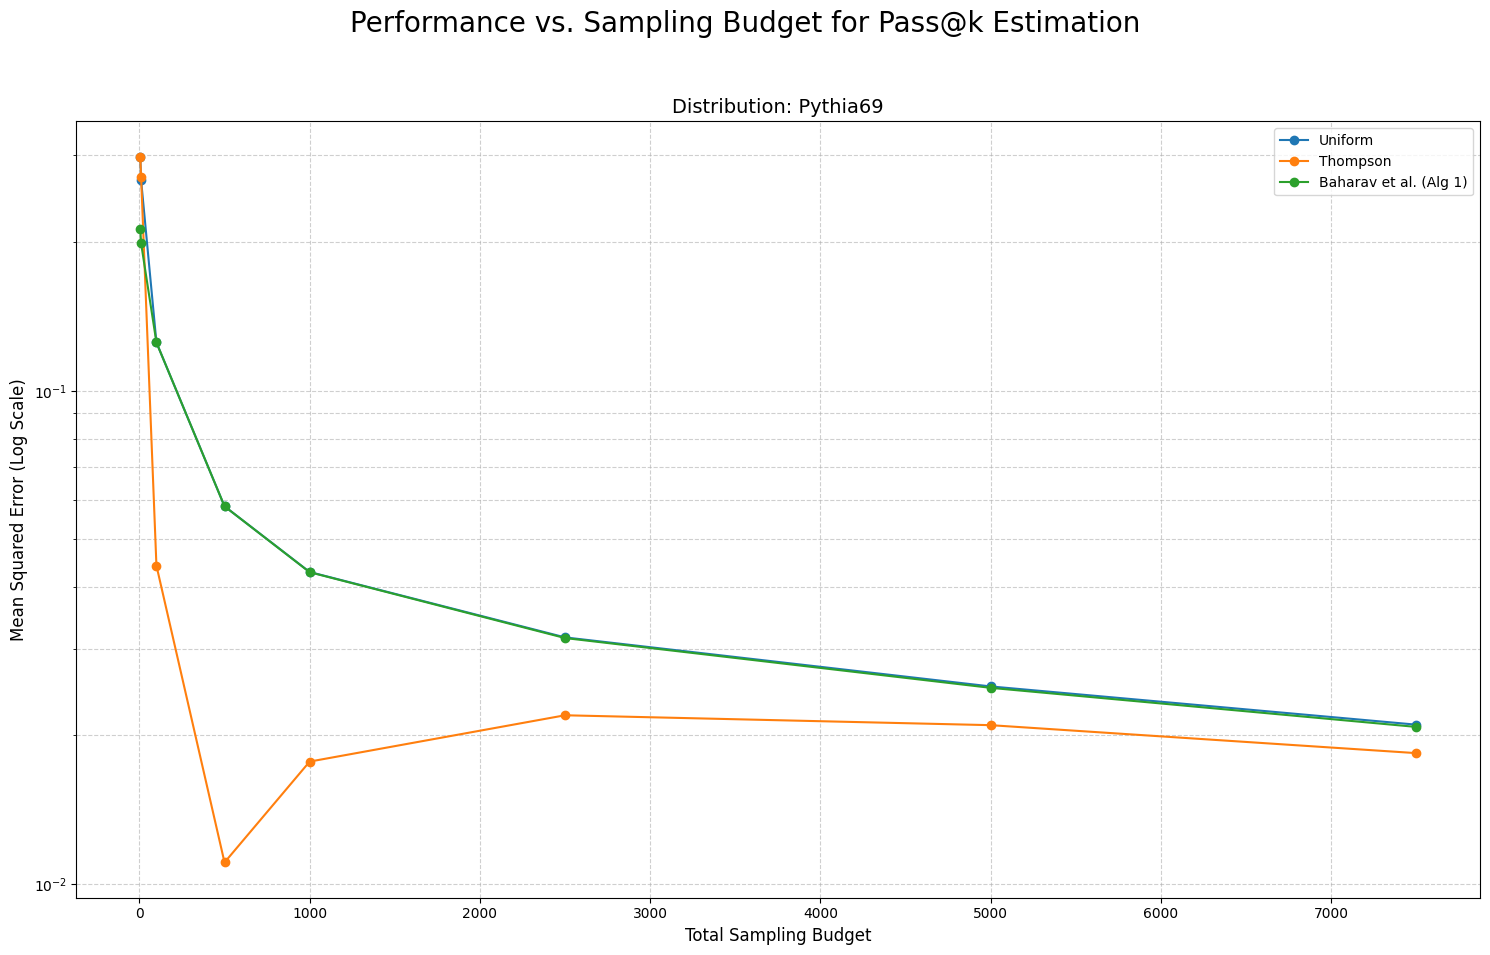

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta as beta_dist
from scipy.special import betaln
import pandas as pd


# --- Simulation Parameters ---
NUM_PROBLEMS = 100
# Define a range of budgets to test
BUDGET_LEVELS = [5,10,100, 500, 1000, 2500, 5000, 7500]
_df_full = pd.read_csv("pythia69_full.csv")
K_VALUES_ALL = _df_full["Scaling Parameter"].unique()
NUM_SIMULATION_RUNS = 50 # Number of times to run for stable results

# --- Problem Set Generation ---
def generate_problem_set_real(csv_path: str = "pythia69k=1.csv"):
    df = pd.read_csv(csv_path)

    successes = df["Num. Samples Correct"].to_numpy(dtype=float)
    totals = df["Num. Samples Total"].to_numpy(dtype=float)
    probs = np.divide(successes, totals)

    # Truncate to NUM_PROBLEMS
    if len(probs) < NUM_PROBLEMS:
        print(f"Warning: CSV has {len(probs)} problems, but NUM_PROBLEMS is {NUM_PROBLEMS}. generate_problem_set_real returning NONE.")
        return None
    else:
        probs = probs[:NUM_PROBLEMS]
    return probs 

def generate_problem_set_synthetic(distribution_type: str):
    """
    Generates a set of true pass@1 probabilities based on a distribution type.

    Args:
        distribution_type: One of 'uniform', 'hard_outlier', 'many_hard'.

    Returns:
        A numpy array of true pass@1 probabilities for each problem.
    """
    if distribution_type == 'uniform':
        # Problems have difficulties ranging from 1% to 10%
        return np.random.uniform(0.01, 0.1, NUM_PROBLEMS)

    elif distribution_type == 'hard_outlier':
        # One extremely hard problem, the rest are easy.
        probs = np.random.uniform(0.1, 0.3, NUM_PROBLEMS)
        probs[0] = 1e-4  # The "needle"
        return probs

    elif distribution_type == 'many_hard':
        # A large fraction of problems are extremely hard.
        num_hard = int(0.3 * NUM_PROBLEMS) # 30% are very hard
        hard_probs = np.random.uniform(1e-5, 1e-4, num_hard)
        easy_probs = np.random.uniform(0.05, 0.2, NUM_PROBLEMS - num_hard)
        return np.concatenate([hard_probs, easy_probs])

    else:
        raise ValueError("Unknown distribution type")

# --- Core Estimator ---

def estimate_pass_k(successes, attempts, k):
    """Estimates pass@k using the Beta-Binomial model."""
    alpha_prior, beta_prior = 1, 1

    valid_attempts = np.where(attempts > 0)
    if len(valid_attempts[0]) == 0:
        return 0

    post_alpha = alpha_prior + successes[valid_attempts]
    post_beta = beta_prior + attempts[valid_attempts] - successes[valid_attempts]

    log_beta_num = betaln(post_alpha, post_beta + k)
    log_beta_den = betaln(post_alpha, post_beta)

    expected_fail_prob_at_k = np.exp(log_beta_num - log_beta_den)
    pass_k_per_problem = 1 - expected_fail_prob_at_k

    total_pass_k = np.sum(pass_k_per_problem)
    return total_pass_k / NUM_PROBLEMS

def get_true_pass_k_real(k, csv_path: str = "pythia69_full.csv"):
    df = pd.read_csv(csv_path)

    subset = df[df["Scaling Parameter"] == k]
    if subset.empty:
        raise ValueError(f"No rows with Scaling Parameter == {k} in {csv_path}")

    #truncate to NUM_PROBLEMS
    if len(subset) < NUM_PROBLEMS:
        print(f"Warning: CSV has {len(subset)} problems, but NUM_PROBLEMS is set to {NUM_PROBLEMS}. Returning None.")
        return None
    else:
        subset = subset[:NUM_PROBLEMS]
    return float(subset["Score"].mean())

def get_true_pass_k_synthetic(problems, k):
    """Calculates the true pass@k from the ground truth probabilities."""
    return np.mean(1 - (1 - problems)**k)

# --- Sampling Strategies ---

def uniform_sampling(problems, budget, k_val):
    """Allocates budget uniformly."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)

    samples_per_problem = budget // len(problems)
    if samples_per_problem == 0:
        for _ in range(budget):
            idx = np.random.randint(len(problems))
            attempts[idx] += 1
            successes[idx] += np.random.binomial(1, problems[idx])
        return successes, attempts

    for i in range(len(problems)):
        s = np.random.binomial(samples_per_problem, problems[i])
        attempts[i] = samples_per_problem
        successes[i] = s
    return successes, attempts

def thompson_sampling(problems, budget, k_val):
    """Inverse Thompson Sampling: samples the problem most likely to be hard."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)
    alphas = np.ones(len(problems))
    betas = np.ones(len(problems))

    for _ in range(budget):
        theta_samples = beta_dist.rvs(alphas, betas)
        problem_idx = np.argmin(theta_samples)
        result = 1 if np.random.rand() < problems[problem_idx] else 0
        attempts[problem_idx] += 1
        if result == 1:
            successes[problem_idx] += 1
            alphas[problem_idx] += 1
        else:
            betas[problem_idx] += 1
    return successes, attempts

def baharav_et_al_sampling(problems, budget, k_val):
    """Implements Algorithm 1 from Baharav et al. (2022) in a fixed-budget setting."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)

    remaining_budget = budget
    # Start with a small base budget for the first round
    base_round_budget = len(problems) * 4
    r = 0

    while remaining_budget > 0:
        # Use doubling budgets for each round
        round_budget = int(min(base_round_budget * (2**r), remaining_budget))
        if round_budget < len(problems): # Ensure at least 1 sample per problem in exploration
            round_budget = remaining_budget

        remaining_budget -= round_budget
        r += 1

        # Phase 1: Exploration (e.g., 50% of round budget)
        explore_samples = max(len(problems), int(0.5 * round_budget))
        samples_per_problem = explore_samples // len(problems)

        if samples_per_problem > 0:
            for i in range(len(problems)):
                s = np.random.binomial(samples_per_problem, problems[i])
                attempts[i] += samples_per_problem
                successes[i] += s

        # Phase 2: Adaptive Concentration (rest of round budget)
        concentrate_samples = round_budget - (samples_per_problem * len(problems))
        if concentrate_samples <= 0:
            continue

        # Estimate p_hats based on all data so far
        # Add a small epsilon to avoid division by zero
        p_hats = (successes + 1e-9) / (attempts + 2e-9)

        # Calculate gradient magnitudes (proportional to (1-p_hat)^(k-1))
        # Handle potential underflow with large k by working in log space
        with np.errstate(invalid='ignore'): # Ignore warnings for log(negative)
             log_grads = (k_val - 1) * np.log(1 - p_hats + 1e-9)

        # Normalize to get allocation probabilities
        # Subtract max for numerical stability before exponentiating
        log_grads -= np.nanmax(log_grads)
        grads = np.exp(log_grads)
        alloc_probs = grads / np.nansum(grads)

        # If all grads are zero (underflow) or nan, fallback to uniform
        if np.isnan(alloc_probs).any() or np.sum(alloc_probs) == 0:
            alloc_probs = np.ones(len(problems)) / len(problems)

        # Sample according to allocation probabilities
        adaptive_pulls = np.random.multinomial(concentrate_samples, alloc_probs)

        for i in range(len(problems)):
            if adaptive_pulls[i] > 0:
                s = np.random.binomial(adaptive_pulls[i], problems[i])
                attempts[i] += adaptive_pulls[i]
                successes[i] += s

    return successes, attempts


# --- Main Simulation and Plotting ---

def run_simulation():
    """Runs the simulation across all budget levels."""

    distributions = ['pythia69'] 
    strategies = {
        'Uniform': uniform_sampling,
        'Thompson': thompson_sampling,
        'Baharav et al. (Alg 1)': baharav_et_al_sampling,
    }

    results = {dist: {name: {budget: [] for budget in BUDGET_LEVELS} for name in strategies} for dist in distributions}

    print(f"Running {NUM_SIMULATION_RUNS} simulations for each distribution and budget...")

    for i in range(NUM_SIMULATION_RUNS):
        if (i+1) % 10 == 0:
            print(f"  ...run {i+1}/{NUM_SIMULATION_RUNS}")
        for dist_type in distributions:
            problem_set = generate_problem_set_real()
            for budget in BUDGET_LEVELS:
                for name, func in strategies.items():
                    errs = []
                    for k in K_VALUES_ALL:
                        if k <= budget:          # only k > budget
                            continue
                        s, a = func(problem_set, budget, k)
                        true_pk = get_true_pass_k_real(k)
                        est_pk  = estimate_pass_k(s, a, k)
                        errs.append((est_pk - true_pk) ** 2)
                    mse = float(np.mean(errs))
                    results[dist_type][name][budget].append(mse)

    avg_results = {dist: {name: {budget: np.mean(mses) for budget, mses in budgets.items()}
                           for name, budgets in strats.items()}
                   for dist, strats in results.items()}

    return avg_results

def plot_results(results):
    """Plots the results as line graphs showing MSE vs. Budget."""

    distributions = list(results.keys())
    fig, axes = plt.subplots(1, len(distributions), figsize=(15, 10), sharey=True)
    fig.suptitle('Performance vs. Sampling Budget for Pass@k Estimation', fontsize=20)

    if len(distributions) == 1:
        axes = [axes]
    for i, dist_type in enumerate(distributions):
        ax = axes[i]
        df = pd.DataFrame(results[dist_type])

        for strategy_name in df.columns:
            ax.plot(df.index, df[strategy_name], marker='o', linestyle='-', label=strategy_name)

        ax.set_title(f'Distribution: {dist_type.replace("_", " ").title()}', fontsize=14)
        ax.set_xlabel('Total Sampling Budget', fontsize=12)
        if i == 0:
            ax.set_ylabel('Mean Squared Error (Log Scale)', fontsize=12)
        ax.set_yscale('log')
        ax.grid(True, which="both", ls="--", alpha=0.6)
        ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

if __name__ == '__main__':
    final_results = run_simulation()

    print("\n--- Average Mean Squared Error vs. Budget ---")
    for dist, strats in final_results.items():
        print(f"\n--- Distribution: {dist} ---")
        print(pd.DataFrame(strats))

    plot_results(final_results)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta as beta_dist
from scipy.special import betaln
import pandas as pd


# --- Simulation Parameters ---
NUM_PROBLEMS = 100
# Define a range of budgets to test
BUDGET_LEVELS = [5,10,100, 500, 1000, 2500, 5000, 7500]
_df_full = pd.read_csv("pythia69_full.csv")
K_VALUES_ALL = _df_full["Scaling Parameter"].unique()
NUM_SIMULATION_RUNS = 1 # Number of times to run for stable results
FIXED_BUDGET=1000
# --- Problem Set Generation ---
def generate_problem_set_real(csv_path: str = "pythia69k=1.csv"):
    df = pd.read_csv(csv_path)

    successes = df["Num. Samples Correct"].to_numpy(dtype=float)
    totals = df["Num. Samples Total"].to_numpy(dtype=float)
    probs = np.divide(successes, totals)

    # Truncate to NUM_PROBLEMS
    if len(probs) < NUM_PROBLEMS:
        print(f"Warning: CSV has {len(probs)} problems, but NUM_PROBLEMS is {NUM_PROBLEMS}. generate_problem_set_real returning NONE.")
        return None
    else:
        probs = probs[:NUM_PROBLEMS]
    return probs 

def generate_problem_set_synthetic(distribution_type: str):
    """
    Generates a set of true pass@1 probabilities based on a distribution type.

    Args:
        distribution_type: One of 'uniform', 'hard_outlier', 'many_hard'.

    Returns:
        A numpy array of true pass@1 probabilities for each problem.
    """
    if distribution_type == 'uniform':
        # Problems have difficulties ranging from 1% to 10%
        return np.random.uniform(0.01, 0.1, NUM_PROBLEMS)

    elif distribution_type == 'hard_outlier':
        # One extremely hard problem, the rest are easy.
        probs = np.random.uniform(0.1, 0.3, NUM_PROBLEMS)
        probs[0] = 1e-4  # The "needle"
        return probs

    elif distribution_type == 'many_hard':
        # A large fraction of problems are extremely hard.
        num_hard = int(0.3 * NUM_PROBLEMS) # 30% are very hard
        hard_probs = np.random.uniform(1e-5, 1e-4, num_hard)
        easy_probs = np.random.uniform(0.05, 0.2, NUM_PROBLEMS - num_hard)
        return np.concatenate([hard_probs, easy_probs])

    else:
        raise ValueError("Unknown distribution type")

# --- Core Estimator ---

def estimate_pass_k(successes, attempts, k):
    """Estimates pass@k using the Beta-Binomial model."""
    alpha_prior, beta_prior = 1, 1

    valid_attempts = np.where(attempts > 0)
    if len(valid_attempts[0]) == 0:
        return 0

    post_alpha = alpha_prior + successes[valid_attempts]
    post_beta = beta_prior + attempts[valid_attempts] - successes[valid_attempts]

    log_beta_num = betaln(post_alpha, post_beta + k)
    log_beta_den = betaln(post_alpha, post_beta)

    expected_fail_prob_at_k = np.exp(log_beta_num - log_beta_den)
    pass_k_per_problem = 1 - expected_fail_prob_at_k

    total_pass_k = np.sum(pass_k_per_problem)
    return total_pass_k / NUM_PROBLEMS

def get_true_pass_k_real(k, csv_path: str = "pythia69_full.csv"):
    df = pd.read_csv(csv_path)

    subset = df[df["Scaling Parameter"] == k]
    if subset.empty:
        raise ValueError(f"No rows with Scaling Parameter == {k} in {csv_path}")

    #truncate to NUM_PROBLEMS
    if len(subset) < NUM_PROBLEMS:
        print(f"Warning: CSV has {len(subset)} problems, but NUM_PROBLEMS is set to {NUM_PROBLEMS}. Returning None.")
        return None
    else:
        subset = subset[:NUM_PROBLEMS]
    return float(subset["Score"].mean())

def get_true_pass_k_synthetic(problems, k):
    """Calculates the true pass@k from the ground truth probabilities."""
    return np.mean(1 - (1 - problems)**k)

# --- Sampling Strategies ---

def uniform_sampling(problems, budget, k_val):
    """Allocates budget uniformly."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)

    samples_per_problem = budget // len(problems)
    if samples_per_problem == 0:
        for _ in range(budget):
            idx = np.random.randint(len(problems))
            attempts[idx] += 1
            successes[idx] += np.random.binomial(1, problems[idx])
        return successes, attempts

    for i in range(len(problems)):
        s = np.random.binomial(samples_per_problem, problems[i])
        attempts[i] = samples_per_problem
        successes[i] = s
    return successes, attempts

def thompson_sampling(problems, budget, k_val):
    """Inverse Thompson Sampling: samples the problem most likely to be hard."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)
    alphas = np.ones(len(problems))
    betas = np.ones(len(problems))

    for _ in range(budget):
        theta_samples = beta_dist.rvs(alphas, betas)
        problem_idx = np.argmin(theta_samples)
        result = 1 if np.random.rand() < problems[problem_idx] else 0
        attempts[problem_idx] += 1
        if result == 1:
            successes[problem_idx] += 1
            alphas[problem_idx] += 1
        else:
            betas[problem_idx] += 1
    return successes, attempts

def baharav_et_al_sampling(problems, budget, k_val):
    """Implements Algorithm 1 from Baharav et al. (2022) in a fixed-budget setting."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)

    remaining_budget = budget
    # Start with a small base budget for the first round
    base_round_budget = len(problems) * 4
    r = 0

    while remaining_budget > 0:
        # Use doubling budgets for each round
        round_budget = int(min(base_round_budget * (2**r), remaining_budget))
        if round_budget < len(problems): # Ensure at least 1 sample per problem in exploration
            round_budget = remaining_budget

        remaining_budget -= round_budget
        r += 1

        # Phase 1: Exploration (e.g., 50% of round budget)
        explore_samples = max(len(problems), int(0.5 * round_budget))
        samples_per_problem = explore_samples // len(problems)

        if samples_per_problem > 0:
            for i in range(len(problems)):
                s = np.random.binomial(samples_per_problem, problems[i])
                attempts[i] += samples_per_problem
                successes[i] += s

        # Phase 2: Adaptive Concentration (rest of round budget)
        concentrate_samples = round_budget - (samples_per_problem * len(problems))
        if concentrate_samples <= 0:
            continue

        # Estimate p_hats based on all data so far
        # Add a small epsilon to avoid division by zero
        p_hats = (successes + 1e-9) / (attempts + 2e-9)

        # Calculate gradient magnitudes (proportional to (1-p_hat)^(k-1))
        # Handle potential underflow with large k by working in log space
        with np.errstate(invalid='ignore'): # Ignore warnings for log(negative)
             log_grads = (k_val - 1) * np.log(1 - p_hats + 1e-9)

        # Normalize to get allocation probabilities
        # Subtract max for numerical stability before exponentiating
        log_grads -= np.nanmax(log_grads)
        grads = np.exp(log_grads)
        alloc_probs = grads / np.nansum(grads)

        # If all grads are zero (underflow) or nan, fallback to uniform
        if np.isnan(alloc_probs).any() or np.sum(alloc_probs) == 0:
            alloc_probs = np.ones(len(problems)) / len(problems)

        # Sample according to allocation probabilities
        adaptive_pulls = np.random.multinomial(concentrate_samples, alloc_probs)

        for i in range(len(problems)):
            if adaptive_pulls[i] > 0:
                s = np.random.binomial(adaptive_pulls[i], problems[i])
                attempts[i] += adaptive_pulls[i]
                successes[i] += s

    return successes, attempts


# --- Main Simulation and Plotting ---

def run_simulation():
    """Runs the simulation across all budget levels."""

    distributions = ['pythia69'] 
    strategies = {
        'Uniform': uniform_sampling,
        'Thompson': thompson_sampling,
        'Baharav et al. (Alg 1)': baharav_et_al_sampling,
    }


    print(f"Running {NUM_SIMULATION_RUNS} simulations for each distribution and budget...")
    K_VALUES = [k for k in K_VALUES_ALL if k > FIXED_BUDGET]
    results = {
        dist: {
            name: {k: [] for k in K_VALUES}
            for name in strategies
        }
        for dist in distributions
    }
    for i in range(NUM_SIMULATION_RUNS):
        print(f"  ...run {i+1}/{NUM_SIMULATION_RUNS}")
        for dist_type in distributions:
            problem_set = generate_problem_set_real()
            for k in K_VALUES:
                for name, func in strategies.items():
                    errs = []
                
                    s, a = func(problem_set, FIXED_BUDGET, k)
                    true_pk = get_true_pass_k_real(k)
                    est_pk  = estimate_pass_k(s, a, k)
                    errs.append((est_pk - true_pk) ** 2)
                    mse = float(np.mean(errs))
                    results[dist_type][name][FIXED_BUDGET].append(mse)

    avg_results = {dist: {name: {k: np.mean(ms) for k, ms in k_dict.items()}
                           for name, k_dict in strat_dict.items()}
                   for dist, strat_dict in results.items()}

    return avg_results

def plot_results(results):
    """Plots the results as line graphs showing MSE vs. Budget."""

    distributions = list(results.keys())
    fig, axes = plt.subplots(1, len(distributions), figsize=(15, 10), sharey=True)
    fig.suptitle('Performance vs. Sampling Budget for Pass@k Estimation', fontsize=20)

    if len(distributions) == 1:
        axes = [axes]
    for i, dist_type in enumerate(distributions):
        ax = axes[i]
        df = pd.DataFrame(results[dist_type])

        for strategy_name in df.columns:
            ax.plot(df.index, df[strategy_name], marker='o', linestyle='-', label=strategy_name)

        ax.set_title(f'Distribution: {dist_type.replace("_", " ").title()}', fontsize=14)
        ax.set_xlabel('k', fontsize=12)
        if i == 0:
            ax.set_ylabel('Mean Squared Error (Log Scale)', fontsize=12)
        ax.set_yscale('log')
        ax.grid(True, which="both", ls="--", alpha=0.6)
        ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

if __name__ == '__main__':
    final_results = run_simulation()

    print("\n--- Average Mean Squared Error vs. Budget ---")
    for dist, strats in final_results.items():
        print(f"\n--- Distribution: {dist} ---")
        print(pd.DataFrame(strats))

    plot_results(final_results)

Running 1 simulations for each distribution and budget...
  ...run 1/1


KeyError: 1000

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta as beta_dist
from scipy.special import betaln
import pandas as pd


# --- Simulation Parameters ---
NUM_PROBLEMS = 100
# Define a range of budgets to test
BUDGET_LEVELS = [5,10,100, 500, 1000, 2500, 5000, 7500]
_df_full = pd.read_csv("pythia69_full.csv")
K_VALUES_ALL = _df_full["Scaling Parameter"].unique()
NUM_SIMULATION_RUNS = 1 # Number of times to run for stable results
FIXED_BUDGET=1000
# --- Problem Set Generation ---
def generate_problem_set_real(csv_path: str = "pythia69k=1.csv"):
    df = pd.read_csv(csv_path)

    successes = df["Num. Samples Correct"].to_numpy(dtype=float)
    totals = df["Num. Samples Total"].to_numpy(dtype=float)
    probs = np.divide(successes, totals)

    # Truncate to NUM_PROBLEMS
    if len(probs) < NUM_PROBLEMS:
        print(f"Warning: CSV has {len(probs)} problems, but NUM_PROBLEMS is {NUM_PROBLEMS}. generate_problem_set_real returning NONE.")
        return None
    else:
        probs = probs[:NUM_PROBLEMS]
    return probs 

def generate_problem_set_synthetic(distribution_type: str):
    """
    Generates a set of true pass@1 probabilities based on a distribution type.

    Args:
        distribution_type: One of 'uniform', 'hard_outlier', 'many_hard'.

    Returns:
        A numpy array of true pass@1 probabilities for each problem.
    """
    if distribution_type == 'uniform':
        # Problems have difficulties ranging from 1% to 10%
        return np.random.uniform(0.01, 0.1, NUM_PROBLEMS)

    elif distribution_type == 'hard_outlier':
        # One extremely hard problem, the rest are easy.
        probs = np.random.uniform(0.1, 0.3, NUM_PROBLEMS)
        probs[0] = 1e-4  # The "needle"
        return probs

    elif distribution_type == 'many_hard':
        # A large fraction of problems are extremely hard.
        num_hard = int(0.3 * NUM_PROBLEMS) # 30% are very hard
        hard_probs = np.random.uniform(1e-5, 1e-4, num_hard)
        easy_probs = np.random.uniform(0.05, 0.2, NUM_PROBLEMS - num_hard)
        return np.concatenate([hard_probs, easy_probs])

    else:
        raise ValueError("Unknown distribution type")

# --- Core Estimator ---

def estimate_pass_k(successes, attempts, k):
    """Estimates pass@k using the Beta-Binomial model."""
    alpha_prior, beta_prior = 1, 1

    valid_attempts = np.where(attempts > 0)
    if len(valid_attempts[0]) == 0:
        return 0

    post_alpha = alpha_prior + successes[valid_attempts]
    post_beta = beta_prior + attempts[valid_attempts] - successes[valid_attempts]

    log_beta_num = betaln(post_alpha, post_beta + k)
    log_beta_den = betaln(post_alpha, post_beta)

    expected_fail_prob_at_k = np.exp(log_beta_num - log_beta_den)
    pass_k_per_problem = 1 - expected_fail_prob_at_k

    total_pass_k = np.sum(pass_k_per_problem)
    return total_pass_k / NUM_PROBLEMS

def get_true_pass_k_real(k, csv_path: str = "pythia69_full.csv"):
    df = pd.read_csv(csv_path)

    subset = df[df["Scaling Parameter"] == k]
    if subset.empty:
        raise ValueError(f"No rows with Scaling Parameter == {k} in {csv_path}")

    #truncate to NUM_PROBLEMS
    if len(subset) < NUM_PROBLEMS:
        print(f"Warning: CSV has {len(subset)} problems, but NUM_PROBLEMS is set to {NUM_PROBLEMS}. Returning None.")
        return None
    else:
        subset = subset[:NUM_PROBLEMS]
    return float(subset["Score"].mean())

def get_true_pass_k_synthetic(problems, k):
    """Calculates the true pass@k from the ground truth probabilities."""
    return np.mean(1 - (1 - problems)**k)

# --- Sampling Strategies ---

def uniform_sampling(problems, budget, k_val):
    """Allocates budget uniformly."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)

    samples_per_problem = budget // len(problems)
    if samples_per_problem == 0:
        for _ in range(budget):
            idx = np.random.randint(len(problems))
            attempts[idx] += 1
            successes[idx] += np.random.binomial(1, problems[idx])
        return successes, attempts

    for i in range(len(problems)):
        s = np.random.binomial(samples_per_problem, problems[i])
        attempts[i] = samples_per_problem
        successes[i] = s
    return successes, attempts

def thompson_sampling(problems, budget, k_val):
    """Inverse Thompson Sampling: samples the problem most likely to be hard."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)
    alphas = np.ones(len(problems))
    betas = np.ones(len(problems))

    for _ in range(budget):
        theta_samples = beta_dist.rvs(alphas, betas)
        problem_idx = np.argmin(theta_samples)
        result = 1 if np.random.rand() < problems[problem_idx] else 0
        attempts[problem_idx] += 1
        if result == 1:
            successes[problem_idx] += 1
            alphas[problem_idx] += 1
        else:
            betas[problem_idx] += 1
    return successes, attempts

def baharav_et_al_sampling(problems, budget, k_val):
    """Implements Algorithm 1 from Baharav et al. (2022) in a fixed-budget setting."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)

    remaining_budget = budget
    # Start with a small base budget for the first round
    base_round_budget = len(problems) * 4
    r = 0

    while remaining_budget > 0:
        # Use doubling budgets for each round
        round_budget = int(min(base_round_budget * (2**r), remaining_budget))
        if round_budget < len(problems): # Ensure at least 1 sample per problem in exploration
            round_budget = remaining_budget

        remaining_budget -= round_budget
        r += 1

        # Phase 1: Exploration (e.g., 50% of round budget)
        explore_samples = max(len(problems), int(0.5 * round_budget))
        samples_per_problem = explore_samples // len(problems)

        if samples_per_problem > 0:
            for i in range(len(problems)):
                s = np.random.binomial(samples_per_problem, problems[i])
                attempts[i] += samples_per_problem
                successes[i] += s

        # Phase 2: Adaptive Concentration (rest of round budget)
        concentrate_samples = round_budget - (samples_per_problem * len(problems))
        if concentrate_samples <= 0:
            continue

        # Estimate p_hats based on all data so far
        # Add a small epsilon to avoid division by zero
        p_hats = (successes + 1e-9) / (attempts + 2e-9)

        # Calculate gradient magnitudes (proportional to (1-p_hat)^(k-1))
        # Handle potential underflow with large k by working in log space
        with np.errstate(invalid='ignore'): # Ignore warnings for log(negative)
             log_grads = (k_val - 1) * np.log(1 - p_hats + 1e-9)

        # Normalize to get allocation probabilities
        # Subtract max for numerical stability before exponentiating
        log_grads -= np.nanmax(log_grads)
        grads = np.exp(log_grads)
        alloc_probs = grads / np.nansum(grads)

        # If all grads are zero (underflow) or nan, fallback to uniform
        if np.isnan(alloc_probs).any() or np.sum(alloc_probs) == 0:
            alloc_probs = np.ones(len(problems)) / len(problems)

        # Sample according to allocation probabilities
        adaptive_pulls = np.random.multinomial(concentrate_samples, alloc_probs)

        for i in range(len(problems)):
            if adaptive_pulls[i] > 0:
                s = np.random.binomial(adaptive_pulls[i], problems[i])
                attempts[i] += adaptive_pulls[i]
                successes[i] += s

    return successes, attempts


# --- Main Simulation and Plotting ---

def run_simulation():
    """Runs the simulation across all budget levels."""

    distributions = ['pythia69'] 
    strategies = {
        'Uniform': uniform_sampling,
        'Thompson': thompson_sampling,
        'Baharav et al. (Alg 1)': baharav_et_al_sampling,
    }


    print(f"Running {NUM_SIMULATION_RUNS} simulations for each distribution and budget...")
    K_VALUES = [k for k in K_VALUES_ALL if k > FIXED_BUDGET]
    results = {
        dist: {
            name: {k: [] for k in K_VALUES}
            for name in strategies
        }
        for dist in distributions
    }
    for i in range(NUM_SIMULATION_RUNS):
        print(f"  ...run {i+1}/{NUM_SIMULATION_RUNS}")
        for dist_type in distributions:
            problem_set = generate_problem_set_real()
            for k in K_VALUES:
                for name, func in strategies.items():
                    errs = []
                
                    s, a = func(problem_set, FIXED_BUDGET, k)
                    true_pk = get_true_pass_k_real(k)
                    est_pk  = estimate_pass_k(s, a, k)
                    errs.append((est_pk - true_pk) ** 2)
                    mse = float(np.mean(errs))
                    results[dist_type][name][FIXED_BUDGET].append(mse)

    avg_results = {dist: {name: {k: np.mean(ms) for k, ms in k_dict.items()}
                           for name, k_dict in strat_dict.items()}
                   for dist, strat_dict in results.items()}

    return avg_results

def plot_results(results):
    """Plots the results as line graphs showing MSE vs. Budget."""

    distributions = list(results.keys())
    fig, axes = plt.subplots(1, len(distributions), figsize=(15, 10), sharey=True)
    fig.suptitle('Performance vs. Sampling Budget for Pass@k Estimation', fontsize=20)

    if len(distributions) == 1:
        axes = [axes]
    for i, dist_type in enumerate(distributions):
        ax = axes[i]
        df = pd.DataFrame(results[dist_type])

        for strategy_name in df.columns:
            ax.plot(df.index, df[strategy_name], marker='o', linestyle='-', label=strategy_name)

        ax.set_title(f'Distribution: {dist_type.replace("_", " ").title()}', fontsize=14)
        ax.set_xlabel('k', fontsize=12)
        if i == 0:
            ax.set_ylabel('Mean Squared Error (Log Scale)', fontsize=12)
        ax.set_yscale('log')
        ax.grid(True, which="both", ls="--", alpha=0.6)
        ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

if __name__ == '__main__':
    final_results = run_simulation()

    print("\n--- Average Mean Squared Error vs. Budget ---")
    for dist, strats in final_results.items():
        print(f"\n--- Distribution: {dist} ---")
        print(pd.DataFrame(strats))

    plot_results(final_results)

Running 1 simulations for each distribution and budget...
  ...run 1/1


KeyError: 1000

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta as beta_dist
from scipy.special import betaln
import pandas as pd


# --- Simulation Parameters ---
NUM_PROBLEMS = 100
# Define a range of budgets to test
BUDGET_LEVELS = [5,10,100, 500, 1000, 2500, 5000, 7500]
_df_full = pd.read_csv("pythia69_full.csv")
K_VALUES_ALL = _df_full["Scaling Parameter"].unique()
NUM_SIMULATION_RUNS = 1 # Number of times to run for stable results
FIXED_BUDGET=1000
# --- Problem Set Generation ---
def generate_problem_set_real(csv_path: str = "pythia69k=1.csv"):
    df = pd.read_csv(csv_path)

    successes = df["Num. Samples Correct"].to_numpy(dtype=float)
    totals = df["Num. Samples Total"].to_numpy(dtype=float)
    probs = np.divide(successes, totals)

    # Truncate to NUM_PROBLEMS
    if len(probs) < NUM_PROBLEMS:
        print(f"Warning: CSV has {len(probs)} problems, but NUM_PROBLEMS is {NUM_PROBLEMS}. generate_problem_set_real returning NONE.")
        return None
    else:
        probs = probs[:NUM_PROBLEMS]
    return probs 

def generate_problem_set_synthetic(distribution_type: str):
    """
    Generates a set of true pass@1 probabilities based on a distribution type.

    Args:
        distribution_type: One of 'uniform', 'hard_outlier', 'many_hard'.

    Returns:
        A numpy array of true pass@1 probabilities for each problem.
    """
    if distribution_type == 'uniform':
        # Problems have difficulties ranging from 1% to 10%
        return np.random.uniform(0.01, 0.1, NUM_PROBLEMS)

    elif distribution_type == 'hard_outlier':
        # One extremely hard problem, the rest are easy.
        probs = np.random.uniform(0.1, 0.3, NUM_PROBLEMS)
        probs[0] = 1e-4  # The "needle"
        return probs

    elif distribution_type == 'many_hard':
        # A large fraction of problems are extremely hard.
        num_hard = int(0.3 * NUM_PROBLEMS) # 30% are very hard
        hard_probs = np.random.uniform(1e-5, 1e-4, num_hard)
        easy_probs = np.random.uniform(0.05, 0.2, NUM_PROBLEMS - num_hard)
        return np.concatenate([hard_probs, easy_probs])

    else:
        raise ValueError("Unknown distribution type")

# --- Core Estimator ---

def estimate_pass_k(successes, attempts, k):
    """Estimates pass@k using the Beta-Binomial model."""
    alpha_prior, beta_prior = 1, 1

    valid_attempts = np.where(attempts > 0)
    if len(valid_attempts[0]) == 0:
        return 0

    post_alpha = alpha_prior + successes[valid_attempts]
    post_beta = beta_prior + attempts[valid_attempts] - successes[valid_attempts]

    log_beta_num = betaln(post_alpha, post_beta + k)
    log_beta_den = betaln(post_alpha, post_beta)

    expected_fail_prob_at_k = np.exp(log_beta_num - log_beta_den)
    pass_k_per_problem = 1 - expected_fail_prob_at_k

    total_pass_k = np.sum(pass_k_per_problem)
    return total_pass_k / NUM_PROBLEMS

def get_true_pass_k_real(k, csv_path: str = "pythia69_full.csv"):
    df = pd.read_csv(csv_path)

    subset = df[df["Scaling Parameter"] == k]
    if subset.empty:
        raise ValueError(f"No rows with Scaling Parameter == {k} in {csv_path}")

    #truncate to NUM_PROBLEMS
    if len(subset) < NUM_PROBLEMS:
        print(f"Warning: CSV has {len(subset)} problems, but NUM_PROBLEMS is set to {NUM_PROBLEMS}. Returning None.")
        return None
    else:
        subset = subset[:NUM_PROBLEMS]
    return float(subset["Score"].mean())

def get_true_pass_k_synthetic(problems, k):
    """Calculates the true pass@k from the ground truth probabilities."""
    return np.mean(1 - (1 - problems)**k)

# --- Sampling Strategies ---

def uniform_sampling(problems, budget, k_val):
    """Allocates budget uniformly."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)

    samples_per_problem = budget // len(problems)
    if samples_per_problem == 0:
        for _ in range(budget):
            idx = np.random.randint(len(problems))
            attempts[idx] += 1
            successes[idx] += np.random.binomial(1, problems[idx])
        return successes, attempts

    for i in range(len(problems)):
        s = np.random.binomial(samples_per_problem, problems[i])
        attempts[i] = samples_per_problem
        successes[i] = s
    return successes, attempts

def thompson_sampling(problems, budget, k_val):
    """Inverse Thompson Sampling: samples the problem most likely to be hard."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)
    alphas = np.ones(len(problems))
    betas = np.ones(len(problems))

    for _ in range(budget):
        theta_samples = beta_dist.rvs(alphas, betas)
        problem_idx = np.argmin(theta_samples)
        result = 1 if np.random.rand() < problems[problem_idx] else 0
        attempts[problem_idx] += 1
        if result == 1:
            successes[problem_idx] += 1
            alphas[problem_idx] += 1
        else:
            betas[problem_idx] += 1
    return successes, attempts

def baharav_et_al_sampling(problems, budget, k_val):
    """Implements Algorithm 1 from Baharav et al. (2022) in a fixed-budget setting."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)

    remaining_budget = budget
    # Start with a small base budget for the first round
    base_round_budget = len(problems) * 4
    r = 0

    while remaining_budget > 0:
        # Use doubling budgets for each round
        round_budget = int(min(base_round_budget * (2**r), remaining_budget))
        if round_budget < len(problems): # Ensure at least 1 sample per problem in exploration
            round_budget = remaining_budget

        remaining_budget -= round_budget
        r += 1

        # Phase 1: Exploration (e.g., 50% of round budget)
        explore_samples = max(len(problems), int(0.5 * round_budget))
        samples_per_problem = explore_samples // len(problems)

        if samples_per_problem > 0:
            for i in range(len(problems)):
                s = np.random.binomial(samples_per_problem, problems[i])
                attempts[i] += samples_per_problem
                successes[i] += s

        # Phase 2: Adaptive Concentration (rest of round budget)
        concentrate_samples = round_budget - (samples_per_problem * len(problems))
        if concentrate_samples <= 0:
            continue

        # Estimate p_hats based on all data so far
        # Add a small epsilon to avoid division by zero
        p_hats = (successes + 1e-9) / (attempts + 2e-9)

        # Calculate gradient magnitudes (proportional to (1-p_hat)^(k-1))
        # Handle potential underflow with large k by working in log space
        with np.errstate(invalid='ignore'): # Ignore warnings for log(negative)
             log_grads = (k_val - 1) * np.log(1 - p_hats + 1e-9)

        # Normalize to get allocation probabilities
        # Subtract max for numerical stability before exponentiating
        log_grads -= np.nanmax(log_grads)
        grads = np.exp(log_grads)
        alloc_probs = grads / np.nansum(grads)

        # If all grads are zero (underflow) or nan, fallback to uniform
        if np.isnan(alloc_probs).any() or np.sum(alloc_probs) == 0:
            alloc_probs = np.ones(len(problems)) / len(problems)

        # Sample according to allocation probabilities
        adaptive_pulls = np.random.multinomial(concentrate_samples, alloc_probs)

        for i in range(len(problems)):
            if adaptive_pulls[i] > 0:
                s = np.random.binomial(adaptive_pulls[i], problems[i])
                attempts[i] += adaptive_pulls[i]
                successes[i] += s

    return successes, attempts


# --- Main Simulation and Plotting ---

def run_simulation():
    """Runs the simulation across all budget levels."""

    distributions = ['pythia69'] 
    strategies = {
        'Uniform': uniform_sampling,
        'Thompson': thompson_sampling,
        'Baharav et al. (Alg 1)': baharav_et_al_sampling,
    }


    print(f"Running {NUM_SIMULATION_RUNS} simulations for each distribution and budget...")
    K_VALUES = [k for k in K_VALUES_ALL if k > FIXED_BUDGET]
    results = {
        dist: {
            name: {k: [] for k in K_VALUES}
            for name in strategies
        }
        for dist in distributions
    }
    for i in range(NUM_SIMULATION_RUNS):
        print(f"  ...run {i+1}/{NUM_SIMULATION_RUNS}")
        for dist_type in distributions:
            problem_set = generate_problem_set_real()
            for k in K_VALUES:
                for name, func in strategies.items():
                    errs = []
                
                    s, a = func(problem_set, FIXED_BUDGET, k)
                    true_pk = get_true_pass_k_real(k)
                    est_pk  = estimate_pass_k(s, a, k)
                    errs.append((est_pk - true_pk) ** 2)
                    mse = float(np.mean(errs))
                    results[dist_type][name][FIXED_BUDGET].append(mse)

    avg_results = {dist: {name: {k: np.mean(ms) for k, ms in k_dict.items()}
                           for name, k_dict in strat_dict.items()}
                   for dist, strat_dict in results.items()}

    return avg_results

def plot_results(results):
    """Plots the results as line graphs showing MSE vs. Budget."""

    distributions = list(results.keys())
    fig, axes = plt.subplots(1, len(distributions), figsize=(15, 10), sharey=True)
    fig.suptitle('Performance vs. Sampling Budget for Pass@k Estimation', fontsize=20)

    if len(distributions) == 1:
        axes = [axes]
    for i, dist_type in enumerate(distributions):
        ax = axes[i]
        df = pd.DataFrame(results[dist_type])

        for strategy_name in df.columns:
            ax.plot(df.index, df[strategy_name], marker='o', linestyle='-', label=strategy_name)

        ax.set_title(f'Distribution: {dist_type.replace("_", " ").title()}', fontsize=14)
        ax.set_xlabel('k', fontsize=12)
        if i == 0:
            ax.set_ylabel('Mean Squared Error (Log Scale)', fontsize=12)
        ax.set_yscale('log')
        ax.grid(True, which="both", ls="--", alpha=0.6)
        ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

if __name__ == '__main__':
    final_results = run_simulation()

    print("\n--- Average Mean Squared Error vs. Budget ---")
    for dist, strats in final_results.items():
        print(f"\n--- Distribution: {dist} ---")
        print(pd.DataFrame(strats))

    plot_results(final_results)

Running 1 simulations for each distribution and budget...
  ...run 1/1


KeyError: 1000

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta as beta_dist
from scipy.special import betaln
import pandas as pd


# --- Simulation Parameters ---
NUM_PROBLEMS = 100
# Define a range of budgets to test
BUDGET_LEVELS = [5,10,100, 500, 1000, 2500, 5000, 7500]
_df_full = pd.read_csv("pythia69_full.csv")
K_VALUES_ALL = _df_full["Scaling Parameter"].unique()
NUM_SIMULATION_RUNS = 1 # Number of times to run for stable results
FIXED_BUDGET=1000
# --- Problem Set Generation ---
def generate_problem_set_real(csv_path: str = "pythia69k=1.csv"):
    df = pd.read_csv(csv_path)

    successes = df["Num. Samples Correct"].to_numpy(dtype=float)
    totals = df["Num. Samples Total"].to_numpy(dtype=float)
    probs = np.divide(successes, totals)

    # Truncate to NUM_PROBLEMS
    if len(probs) < NUM_PROBLEMS:
        print(f"Warning: CSV has {len(probs)} problems, but NUM_PROBLEMS is {NUM_PROBLEMS}. generate_problem_set_real returning NONE.")
        return None
    else:
        probs = probs[:NUM_PROBLEMS]
    return probs 

def generate_problem_set_synthetic(distribution_type: str):
    """
    Generates a set of true pass@1 probabilities based on a distribution type.

    Args:
        distribution_type: One of 'uniform', 'hard_outlier', 'many_hard'.

    Returns:
        A numpy array of true pass@1 probabilities for each problem.
    """
    if distribution_type == 'uniform':
        # Problems have difficulties ranging from 1% to 10%
        return np.random.uniform(0.01, 0.1, NUM_PROBLEMS)

    elif distribution_type == 'hard_outlier':
        # One extremely hard problem, the rest are easy.
        probs = np.random.uniform(0.1, 0.3, NUM_PROBLEMS)
        probs[0] = 1e-4  # The "needle"
        return probs

    elif distribution_type == 'many_hard':
        # A large fraction of problems are extremely hard.
        num_hard = int(0.3 * NUM_PROBLEMS) # 30% are very hard
        hard_probs = np.random.uniform(1e-5, 1e-4, num_hard)
        easy_probs = np.random.uniform(0.05, 0.2, NUM_PROBLEMS - num_hard)
        return np.concatenate([hard_probs, easy_probs])

    else:
        raise ValueError("Unknown distribution type")

# --- Core Estimator ---

def estimate_pass_k(successes, attempts, k):
    """Estimates pass@k using the Beta-Binomial model."""
    alpha_prior, beta_prior = 1, 1

    valid_attempts = np.where(attempts > 0)
    if len(valid_attempts[0]) == 0:
        return 0

    post_alpha = alpha_prior + successes[valid_attempts]
    post_beta = beta_prior + attempts[valid_attempts] - successes[valid_attempts]

    log_beta_num = betaln(post_alpha, post_beta + k)
    log_beta_den = betaln(post_alpha, post_beta)

    expected_fail_prob_at_k = np.exp(log_beta_num - log_beta_den)
    pass_k_per_problem = 1 - expected_fail_prob_at_k

    total_pass_k = np.sum(pass_k_per_problem)
    return total_pass_k / NUM_PROBLEMS

def get_true_pass_k_real(k, csv_path: str = "pythia69_full.csv"):
    df = pd.read_csv(csv_path)

    subset = df[df["Scaling Parameter"] == k]
    if subset.empty:
        raise ValueError(f"No rows with Scaling Parameter == {k} in {csv_path}")

    #truncate to NUM_PROBLEMS
    if len(subset) < NUM_PROBLEMS:
        print(f"Warning: CSV has {len(subset)} problems, but NUM_PROBLEMS is set to {NUM_PROBLEMS}. Returning None.")
        return None
    else:
        subset = subset[:NUM_PROBLEMS]
    return float(subset["Score"].mean())

def get_true_pass_k_synthetic(problems, k):
    """Calculates the true pass@k from the ground truth probabilities."""
    return np.mean(1 - (1 - problems)**k)

# --- Sampling Strategies ---

def uniform_sampling(problems, budget, k_val):
    """Allocates budget uniformly."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)

    samples_per_problem = budget // len(problems)
    if samples_per_problem == 0:
        for _ in range(budget):
            idx = np.random.randint(len(problems))
            attempts[idx] += 1
            successes[idx] += np.random.binomial(1, problems[idx])
        return successes, attempts

    for i in range(len(problems)):
        s = np.random.binomial(samples_per_problem, problems[i])
        attempts[i] = samples_per_problem
        successes[i] = s
    return successes, attempts

def thompson_sampling(problems, budget, k_val):
    """Inverse Thompson Sampling: samples the problem most likely to be hard."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)
    alphas = np.ones(len(problems))
    betas = np.ones(len(problems))

    for _ in range(budget):
        theta_samples = beta_dist.rvs(alphas, betas)
        problem_idx = np.argmin(theta_samples)
        result = 1 if np.random.rand() < problems[problem_idx] else 0
        attempts[problem_idx] += 1
        if result == 1:
            successes[problem_idx] += 1
            alphas[problem_idx] += 1
        else:
            betas[problem_idx] += 1
    return successes, attempts

def baharav_et_al_sampling(problems, budget, k_val):
    """Implements Algorithm 1 from Baharav et al. (2022) in a fixed-budget setting."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)

    remaining_budget = budget
    # Start with a small base budget for the first round
    base_round_budget = len(problems) * 4
    r = 0

    while remaining_budget > 0:
        # Use doubling budgets for each round
        round_budget = int(min(base_round_budget * (2**r), remaining_budget))
        if round_budget < len(problems): # Ensure at least 1 sample per problem in exploration
            round_budget = remaining_budget

        remaining_budget -= round_budget
        r += 1

        # Phase 1: Exploration (e.g., 50% of round budget)
        explore_samples = max(len(problems), int(0.5 * round_budget))
        samples_per_problem = explore_samples // len(problems)

        if samples_per_problem > 0:
            for i in range(len(problems)):
                s = np.random.binomial(samples_per_problem, problems[i])
                attempts[i] += samples_per_problem
                successes[i] += s

        # Phase 2: Adaptive Concentration (rest of round budget)
        concentrate_samples = round_budget - (samples_per_problem * len(problems))
        if concentrate_samples <= 0:
            continue

        # Estimate p_hats based on all data so far
        # Add a small epsilon to avoid division by zero
        p_hats = (successes + 1e-9) / (attempts + 2e-9)

        # Calculate gradient magnitudes (proportional to (1-p_hat)^(k-1))
        # Handle potential underflow with large k by working in log space
        with np.errstate(invalid='ignore'): # Ignore warnings for log(negative)
             log_grads = (k_val - 1) * np.log(1 - p_hats + 1e-9)

        # Normalize to get allocation probabilities
        # Subtract max for numerical stability before exponentiating
        log_grads -= np.nanmax(log_grads)
        grads = np.exp(log_grads)
        alloc_probs = grads / np.nansum(grads)

        # If all grads are zero (underflow) or nan, fallback to uniform
        if np.isnan(alloc_probs).any() or np.sum(alloc_probs) == 0:
            alloc_probs = np.ones(len(problems)) / len(problems)

        # Sample according to allocation probabilities
        adaptive_pulls = np.random.multinomial(concentrate_samples, alloc_probs)

        for i in range(len(problems)):
            if adaptive_pulls[i] > 0:
                s = np.random.binomial(adaptive_pulls[i], problems[i])
                attempts[i] += adaptive_pulls[i]
                successes[i] += s

    return successes, attempts


# --- Main Simulation and Plotting ---

def run_simulation():
    """Runs the simulation across all budget levels."""

    distributions = ['pythia69'] 
    strategies = {
        'Uniform': uniform_sampling,
        'Thompson': thompson_sampling,
        'Baharav et al. (Alg 1)': baharav_et_al_sampling,
    }


    print(f"Running {NUM_SIMULATION_RUNS} simulations for each distribution and budget...")
    K_VALUES = [k for k in K_VALUES_ALL if k > FIXED_BUDGET]
    results = {
        dist: {
            name: {k: [] for k in K_VALUES}
            for name in strategies
        }
        for dist in distributions
    }
    for i in range(NUM_SIMULATION_RUNS):
        print(f"  ...run {i+1}/{NUM_SIMULATION_RUNS}")
        for dist_type in distributions:
            problem_set = generate_problem_set_real()
            for k in K_VALUES:
                for name, func in strategies.items():
                    errs = []
                
                    s, a = func(problem_set, FIXED_BUDGET, k)
                    true_pk = get_true_pass_k_real(k)
                    est_pk  = estimate_pass_k(s, a, k)
                    errs.append((est_pk - true_pk) ** 2)
                    mse = float(np.mean(errs))
                    results[dist_type][name][FIXED_BUDGET].append(mse)

    avg_results = {dist: {name: {k: np.mean(ms) for k, ms in k_dict.items()}
                           for name, k_dict in strat_dict.items()}
                   for dist, strat_dict in results.items()}

    return avg_results

def plot_results(results):
    """Plots the results as line graphs showing MSE vs. Budget."""

    distributions = list(results.keys())
    fig, axes = plt.subplots(1, len(distributions), figsize=(15, 10), sharey=True)
    fig.suptitle('Performance vs. Sampling Budget for Pass@k Estimation', fontsize=20)

    if len(distributions) == 1:
        axes = [axes]
    for i, dist_type in enumerate(distributions):
        ax = axes[i]
        df = pd.DataFrame(results[dist_type])

        for strategy_name in df.columns:
            ax.plot(df.index, df[strategy_name], marker='o', linestyle='-', label=strategy_name)

        ax.set_title(f'Distribution: {dist_type.replace("_", " ").title()}', fontsize=14)
        ax.set_xlabel('k', fontsize=12)
        if i == 0:
            ax.set_ylabel('Mean Squared Error (Log Scale)', fontsize=12)
        ax.set_yscale('log')
        ax.grid(True, which="both", ls="--", alpha=0.6)
        ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

if __name__ == '__main__':
    final_results = run_simulation()

    print("\n--- Average Mean Squared Error vs. Budget ---")
    for dist, strats in final_results.items():
        print(f"\n--- Distribution: {dist} ---")
        print(pd.DataFrame(strats))

    plot_results(final_results)

Running 1 simulations for each distribution and budget...
  ...run 1/1


KeyError: 1000

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta as beta_dist
from scipy.special import betaln
import pandas as pd


# --- Simulation Parameters ---
NUM_PROBLEMS = 100
# Define a range of budgets to test
BUDGET_LEVELS = [5,10,100, 500, 1000, 2500, 5000, 7500]
_df_full = pd.read_csv("pythia69_full.csv")
K_VALUES_ALL = _df_full["Scaling Parameter"].unique()
NUM_SIMULATION_RUNS = 1 # Number of times to run for stable results
FIXED_BUDGET=1000
# --- Problem Set Generation ---
def generate_problem_set_real(csv_path: str = "pythia69k=1.csv"):
    df = pd.read_csv(csv_path)

    successes = df["Num. Samples Correct"].to_numpy(dtype=float)
    totals = df["Num. Samples Total"].to_numpy(dtype=float)
    probs = np.divide(successes, totals)

    # Truncate to NUM_PROBLEMS
    if len(probs) < NUM_PROBLEMS:
        print(f"Warning: CSV has {len(probs)} problems, but NUM_PROBLEMS is {NUM_PROBLEMS}. generate_problem_set_real returning NONE.")
        return None
    else:
        probs = probs[:NUM_PROBLEMS]
    return probs 

def generate_problem_set_synthetic(distribution_type: str):
    """
    Generates a set of true pass@1 probabilities based on a distribution type.

    Args:
        distribution_type: One of 'uniform', 'hard_outlier', 'many_hard'.

    Returns:
        A numpy array of true pass@1 probabilities for each problem.
    """
    if distribution_type == 'uniform':
        # Problems have difficulties ranging from 1% to 10%
        return np.random.uniform(0.01, 0.1, NUM_PROBLEMS)

    elif distribution_type == 'hard_outlier':
        # One extremely hard problem, the rest are easy.
        probs = np.random.uniform(0.1, 0.3, NUM_PROBLEMS)
        probs[0] = 1e-4  # The "needle"
        return probs

    elif distribution_type == 'many_hard':
        # A large fraction of problems are extremely hard.
        num_hard = int(0.3 * NUM_PROBLEMS) # 30% are very hard
        hard_probs = np.random.uniform(1e-5, 1e-4, num_hard)
        easy_probs = np.random.uniform(0.05, 0.2, NUM_PROBLEMS - num_hard)
        return np.concatenate([hard_probs, easy_probs])

    else:
        raise ValueError("Unknown distribution type")

# --- Core Estimator ---

def estimate_pass_k(successes, attempts, k):
    """Estimates pass@k using the Beta-Binomial model."""
    alpha_prior, beta_prior = 1, 1

    valid_attempts = np.where(attempts > 0)
    if len(valid_attempts[0]) == 0:
        return 0

    post_alpha = alpha_prior + successes[valid_attempts]
    post_beta = beta_prior + attempts[valid_attempts] - successes[valid_attempts]

    log_beta_num = betaln(post_alpha, post_beta + k)
    log_beta_den = betaln(post_alpha, post_beta)

    expected_fail_prob_at_k = np.exp(log_beta_num - log_beta_den)
    pass_k_per_problem = 1 - expected_fail_prob_at_k

    total_pass_k = np.sum(pass_k_per_problem)
    return total_pass_k / NUM_PROBLEMS

def get_true_pass_k_real(k, csv_path: str = "pythia69_full.csv"):
    df = pd.read_csv(csv_path)

    subset = df[df["Scaling Parameter"] == k]
    if subset.empty:
        raise ValueError(f"No rows with Scaling Parameter == {k} in {csv_path}")

    #truncate to NUM_PROBLEMS
    if len(subset) < NUM_PROBLEMS:
        print(f"Warning: CSV has {len(subset)} problems, but NUM_PROBLEMS is set to {NUM_PROBLEMS}. Returning None.")
        return None
    else:
        subset = subset[:NUM_PROBLEMS]
    return float(subset["Score"].mean())

def get_true_pass_k_synthetic(problems, k):
    """Calculates the true pass@k from the ground truth probabilities."""
    return np.mean(1 - (1 - problems)**k)

# --- Sampling Strategies ---

def uniform_sampling(problems, budget, k_val):
    """Allocates budget uniformly."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)

    samples_per_problem = budget // len(problems)
    if samples_per_problem == 0:
        for _ in range(budget):
            idx = np.random.randint(len(problems))
            attempts[idx] += 1
            successes[idx] += np.random.binomial(1, problems[idx])
        return successes, attempts

    for i in range(len(problems)):
        s = np.random.binomial(samples_per_problem, problems[i])
        attempts[i] = samples_per_problem
        successes[i] = s
    return successes, attempts

def thompson_sampling(problems, budget, k_val):
    """Inverse Thompson Sampling: samples the problem most likely to be hard."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)
    alphas = np.ones(len(problems))
    betas = np.ones(len(problems))

    for _ in range(budget):
        theta_samples = beta_dist.rvs(alphas, betas)
        problem_idx = np.argmin(theta_samples)
        result = 1 if np.random.rand() < problems[problem_idx] else 0
        attempts[problem_idx] += 1
        if result == 1:
            successes[problem_idx] += 1
            alphas[problem_idx] += 1
        else:
            betas[problem_idx] += 1
    return successes, attempts

def baharav_et_al_sampling(problems, budget, k_val):
    """Implements Algorithm 1 from Baharav et al. (2022) in a fixed-budget setting."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)

    remaining_budget = budget
    # Start with a small base budget for the first round
    base_round_budget = len(problems) * 4
    r = 0

    while remaining_budget > 0:
        # Use doubling budgets for each round
        round_budget = int(min(base_round_budget * (2**r), remaining_budget))
        if round_budget < len(problems): # Ensure at least 1 sample per problem in exploration
            round_budget = remaining_budget

        remaining_budget -= round_budget
        r += 1

        # Phase 1: Exploration (e.g., 50% of round budget)
        explore_samples = max(len(problems), int(0.5 * round_budget))
        samples_per_problem = explore_samples // len(problems)

        if samples_per_problem > 0:
            for i in range(len(problems)):
                s = np.random.binomial(samples_per_problem, problems[i])
                attempts[i] += samples_per_problem
                successes[i] += s

        # Phase 2: Adaptive Concentration (rest of round budget)
        concentrate_samples = round_budget - (samples_per_problem * len(problems))
        if concentrate_samples <= 0:
            continue

        # Estimate p_hats based on all data so far
        # Add a small epsilon to avoid division by zero
        p_hats = (successes + 1e-9) / (attempts + 2e-9)

        # Calculate gradient magnitudes (proportional to (1-p_hat)^(k-1))
        # Handle potential underflow with large k by working in log space
        with np.errstate(invalid='ignore'): # Ignore warnings for log(negative)
             log_grads = (k_val - 1) * np.log(1 - p_hats + 1e-9)

        # Normalize to get allocation probabilities
        # Subtract max for numerical stability before exponentiating
        log_grads -= np.nanmax(log_grads)
        grads = np.exp(log_grads)
        alloc_probs = grads / np.nansum(grads)

        # If all grads are zero (underflow) or nan, fallback to uniform
        if np.isnan(alloc_probs).any() or np.sum(alloc_probs) == 0:
            alloc_probs = np.ones(len(problems)) / len(problems)

        # Sample according to allocation probabilities
        adaptive_pulls = np.random.multinomial(concentrate_samples, alloc_probs)

        for i in range(len(problems)):
            if adaptive_pulls[i] > 0:
                s = np.random.binomial(adaptive_pulls[i], problems[i])
                attempts[i] += adaptive_pulls[i]
                successes[i] += s

    return successes, attempts


# --- Main Simulation and Plotting ---

def run_simulation():
    """Runs the simulation across all budget levels."""

    distributions = ['pythia69'] 
    strategies = {
        'Uniform': uniform_sampling,
        'Thompson': thompson_sampling,
        'Baharav et al. (Alg 1)': baharav_et_al_sampling,
    }


    print(f"Running {NUM_SIMULATION_RUNS} simulations for each distribution and budget...")
    K_VALUES = [k for k in K_VALUES_ALL if k > FIXED_BUDGET]
    results = {
        dist: {
            name: {k: [] for k in K_VALUES}
            for name in strategies
        }
        for dist in distributions
    }
    for i in range(NUM_SIMULATION_RUNS):
        print(f"  ...run {i+1}/{NUM_SIMULATION_RUNS}")
        for dist_type in distributions:
            problem_set = generate_problem_set_real()
            for k in K_VALUES:
                for name, func in strategies.items():
                    errs = []
                
                    s, a = func(problem_set, FIXED_BUDGET, k)
                    true_pk = get_true_pass_k_real(k)
                    est_pk  = estimate_pass_k(s, a, k)
                    errs.append((est_pk - true_pk) ** 2)
                    mse = float(np.mean(errs))
                    results[dist_type][name][FIXED_BUDGET].append(mse)

    avg_results = {dist: {name: {k: np.mean(ms) for k, ms in k_dict.items()}
                           for name, k_dict in strat_dict.items()}
                   for dist, strat_dict in results.items()}

    return avg_results

def plot_results(results):
    """Plots the results as line graphs showing MSE vs. Budget."""

    distributions = list(results.keys())
    fig, axes = plt.subplots(1, len(distributions), figsize=(15, 10), sharey=True)
    fig.suptitle('Performance vs. Sampling Budget for Pass@k Estimation', fontsize=20)

    if len(distributions) == 1:
        axes = [axes]
    for i, dist_type in enumerate(distributions):
        ax = axes[i]
        df = pd.DataFrame(results[dist_type])

        for strategy_name in df.columns:
            ax.plot(df.index, df[strategy_name], marker='o', linestyle='-', label=strategy_name)

        ax.set_title(f'Distribution: {dist_type.replace("_", " ").title()}', fontsize=14)
        ax.set_xlabel('k', fontsize=12)
        if i == 0:
            ax.set_ylabel('Mean Squared Error (Log Scale)', fontsize=12)
        ax.set_yscale('log')
        ax.grid(True, which="both", ls="--", alpha=0.6)
        ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

if __name__ == '__main__':
    final_results = run_simulation()

    print("\n--- Average Mean Squared Error vs. Budget ---")
    for dist, strats in final_results.items():
        print(f"\n--- Distribution: {dist} ---")
        print(pd.DataFrame(strats))

    plot_results(final_results)

Running 1 simulations for each distribution and budget...
  ...run 1/1


KeyError: 1000

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta as beta_dist
from scipy.special import betaln
import pandas as pd


# --- Simulation Parameters ---
NUM_PROBLEMS = 100
# Define a range of budgets to test
BUDGET_LEVELS = [5,10,100, 500, 1000, 2500, 5000, 7500]
_df_full = pd.read_csv("pythia69_full.csv")
K_VALUES_ALL = _df_full["Scaling Parameter"].unique()
NUM_SIMULATION_RUNS = 1 # Number of times to run for stable results
FIXED_BUDGET=1000
# --- Problem Set Generation ---
def generate_problem_set_real(csv_path: str = "pythia69k=1.csv"):
    df = pd.read_csv(csv_path)

    successes = df["Num. Samples Correct"].to_numpy(dtype=float)
    totals = df["Num. Samples Total"].to_numpy(dtype=float)
    probs = np.divide(successes, totals)

    # Truncate to NUM_PROBLEMS
    if len(probs) < NUM_PROBLEMS:
        print(f"Warning: CSV has {len(probs)} problems, but NUM_PROBLEMS is {NUM_PROBLEMS}. generate_problem_set_real returning NONE.")
        return None
    else:
        probs = probs[:NUM_PROBLEMS]
    return probs 

def generate_problem_set_synthetic(distribution_type: str):
    """
    Generates a set of true pass@1 probabilities based on a distribution type.

    Args:
        distribution_type: One of 'uniform', 'hard_outlier', 'many_hard'.

    Returns:
        A numpy array of true pass@1 probabilities for each problem.
    """
    if distribution_type == 'uniform':
        # Problems have difficulties ranging from 1% to 10%
        return np.random.uniform(0.01, 0.1, NUM_PROBLEMS)

    elif distribution_type == 'hard_outlier':
        # One extremely hard problem, the rest are easy.
        probs = np.random.uniform(0.1, 0.3, NUM_PROBLEMS)
        probs[0] = 1e-4  # The "needle"
        return probs

    elif distribution_type == 'many_hard':
        # A large fraction of problems are extremely hard.
        num_hard = int(0.3 * NUM_PROBLEMS) # 30% are very hard
        hard_probs = np.random.uniform(1e-5, 1e-4, num_hard)
        easy_probs = np.random.uniform(0.05, 0.2, NUM_PROBLEMS - num_hard)
        return np.concatenate([hard_probs, easy_probs])

    else:
        raise ValueError("Unknown distribution type")

# --- Core Estimator ---

def estimate_pass_k(successes, attempts, k):
    """Estimates pass@k using the Beta-Binomial model."""
    alpha_prior, beta_prior = 1, 1

    valid_attempts = np.where(attempts > 0)
    if len(valid_attempts[0]) == 0:
        return 0

    post_alpha = alpha_prior + successes[valid_attempts]
    post_beta = beta_prior + attempts[valid_attempts] - successes[valid_attempts]

    log_beta_num = betaln(post_alpha, post_beta + k)
    log_beta_den = betaln(post_alpha, post_beta)

    expected_fail_prob_at_k = np.exp(log_beta_num - log_beta_den)
    pass_k_per_problem = 1 - expected_fail_prob_at_k

    total_pass_k = np.sum(pass_k_per_problem)
    return total_pass_k / NUM_PROBLEMS

def get_true_pass_k_real(k, csv_path: str = "pythia69_full.csv"):
    df = pd.read_csv(csv_path)

    subset = df[df["Scaling Parameter"] == k]
    if subset.empty:
        raise ValueError(f"No rows with Scaling Parameter == {k} in {csv_path}")

    #truncate to NUM_PROBLEMS
    if len(subset) < NUM_PROBLEMS:
        print(f"Warning: CSV has {len(subset)} problems, but NUM_PROBLEMS is set to {NUM_PROBLEMS}. Returning None.")
        return None
    else:
        subset = subset[:NUM_PROBLEMS]
    return float(subset["Score"].mean())

def get_true_pass_k_synthetic(problems, k):
    """Calculates the true pass@k from the ground truth probabilities."""
    return np.mean(1 - (1 - problems)**k)

# --- Sampling Strategies ---

def uniform_sampling(problems, budget, k_val):
    """Allocates budget uniformly."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)

    samples_per_problem = budget // len(problems)
    if samples_per_problem == 0:
        for _ in range(budget):
            idx = np.random.randint(len(problems))
            attempts[idx] += 1
            successes[idx] += np.random.binomial(1, problems[idx])
        return successes, attempts

    for i in range(len(problems)):
        s = np.random.binomial(samples_per_problem, problems[i])
        attempts[i] = samples_per_problem
        successes[i] = s
    return successes, attempts

def thompson_sampling(problems, budget, k_val):
    """Inverse Thompson Sampling: samples the problem most likely to be hard."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)
    alphas = np.ones(len(problems))
    betas = np.ones(len(problems))

    for _ in range(budget):
        theta_samples = beta_dist.rvs(alphas, betas)
        problem_idx = np.argmin(theta_samples)
        result = 1 if np.random.rand() < problems[problem_idx] else 0
        attempts[problem_idx] += 1
        if result == 1:
            successes[problem_idx] += 1
            alphas[problem_idx] += 1
        else:
            betas[problem_idx] += 1
    return successes, attempts

def baharav_et_al_sampling(problems, budget, k_val):
    """Implements Algorithm 1 from Baharav et al. (2022) in a fixed-budget setting."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)

    remaining_budget = budget
    # Start with a small base budget for the first round
    base_round_budget = len(problems) * 4
    r = 0

    while remaining_budget > 0:
        # Use doubling budgets for each round
        round_budget = int(min(base_round_budget * (2**r), remaining_budget))
        if round_budget < len(problems): # Ensure at least 1 sample per problem in exploration
            round_budget = remaining_budget

        remaining_budget -= round_budget
        r += 1

        # Phase 1: Exploration (e.g., 50% of round budget)
        explore_samples = max(len(problems), int(0.5 * round_budget))
        samples_per_problem = explore_samples // len(problems)

        if samples_per_problem > 0:
            for i in range(len(problems)):
                s = np.random.binomial(samples_per_problem, problems[i])
                attempts[i] += samples_per_problem
                successes[i] += s

        # Phase 2: Adaptive Concentration (rest of round budget)
        concentrate_samples = round_budget - (samples_per_problem * len(problems))
        if concentrate_samples <= 0:
            continue

        # Estimate p_hats based on all data so far
        # Add a small epsilon to avoid division by zero
        p_hats = (successes + 1e-9) / (attempts + 2e-9)

        # Calculate gradient magnitudes (proportional to (1-p_hat)^(k-1))
        # Handle potential underflow with large k by working in log space
        with np.errstate(invalid='ignore'): # Ignore warnings for log(negative)
             log_grads = (k_val - 1) * np.log(1 - p_hats + 1e-9)

        # Normalize to get allocation probabilities
        # Subtract max for numerical stability before exponentiating
        log_grads -= np.nanmax(log_grads)
        grads = np.exp(log_grads)
        alloc_probs = grads / np.nansum(grads)

        # If all grads are zero (underflow) or nan, fallback to uniform
        if np.isnan(alloc_probs).any() or np.sum(alloc_probs) == 0:
            alloc_probs = np.ones(len(problems)) / len(problems)

        # Sample according to allocation probabilities
        adaptive_pulls = np.random.multinomial(concentrate_samples, alloc_probs)

        for i in range(len(problems)):
            if adaptive_pulls[i] > 0:
                s = np.random.binomial(adaptive_pulls[i], problems[i])
                attempts[i] += adaptive_pulls[i]
                successes[i] += s

    return successes, attempts


# --- Main Simulation and Plotting ---

def run_simulation():
    """Runs the simulation across all budget levels."""

    distributions = ['pythia69'] 
    strategies = {
        'Uniform': uniform_sampling,
        'Thompson': thompson_sampling,
        'Baharav et al. (Alg 1)': baharav_et_al_sampling,
    }


    print(f"Running {NUM_SIMULATION_RUNS} simulations for each distribution and budget...")
    K_VALUES = [k for k in K_VALUES_ALL if k > FIXED_BUDGET]
    results = {
        dist: {
            name: {k: [] for k in K_VALUES}
            for name in strategies
        }
        for dist in distributions
    }
    for i in range(NUM_SIMULATION_RUNS):
        print(f"  ...run {i+1}/{NUM_SIMULATION_RUNS}")
        for dist_type in distributions:
            problem_set = generate_problem_set_real()
            for k in K_VALUES:
                for name, func in strategies.items():
                    errs = []
                
                    s, a = func(problem_set, FIXED_BUDGET, k)
                    true_pk = get_true_pass_k_real(k)
                    est_pk  = estimate_pass_k(s, a, k)
                    errs.append((est_pk - true_pk) ** 2)
                    mse = float(np.mean(errs))
                    results[dist_type][name][FIXED_BUDGET].append(mse)

    avg_results = {dist: {name: {k: np.mean(ms) for k, ms in k_dict.items()}
                           for name, k_dict in strat_dict.items()}
                   for dist, strat_dict in results.items()}

    return avg_results

def plot_results(results):
    """Plots the results as line graphs showing MSE vs. Budget."""

    distributions = list(results.keys())
    fig, axes = plt.subplots(1, len(distributions), figsize=(15, 10), sharey=True)
    fig.suptitle('Performance vs. Sampling Budget for Pass@k Estimation', fontsize=20)

    if len(distributions) == 1:
        axes = [axes]
    for i, dist_type in enumerate(distributions):
        ax = axes[i]
        df = pd.DataFrame(results[dist_type])

        for strategy_name in df.columns:
            ax.plot(df.index, df[strategy_name], marker='o', linestyle='-', label=strategy_name)

        ax.set_title(f'Distribution: {dist_type.replace("_", " ").title()}', fontsize=14)
        ax.set_xlabel('k', fontsize=12)
        if i == 0:
            ax.set_ylabel('Mean Squared Error (Log Scale)', fontsize=12)
        ax.set_yscale('log')
        ax.grid(True, which="both", ls="--", alpha=0.6)
        ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

if __name__ == '__main__':
    final_results = run_simulation()

    print("\n--- Average Mean Squared Error vs. Budget ---")
    for dist, strats in final_results.items():
        print(f"\n--- Distribution: {dist} ---")
        print(pd.DataFrame(strats))

    plot_results(final_results)

Running 1 simulations for each distribution and budget...
  ...run 1/1


KeyError: 1000

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta as beta_dist
from scipy.special import betaln
import pandas as pd


# --- Simulation Parameters ---
NUM_PROBLEMS = 100
# Define a range of budgets to test
BUDGET_LEVELS = [5,10,100, 500, 1000, 2500, 5000, 7500]
_df_full = pd.read_csv("pythia69_full.csv")
K_VALUES_ALL = _df_full["Scaling Parameter"].unique()
NUM_SIMULATION_RUNS = 1 # Number of times to run for stable results
FIXED_BUDGET=1000
# --- Problem Set Generation ---
def generate_problem_set_real(csv_path: str = "pythia69k=1.csv"):
    df = pd.read_csv(csv_path)

    successes = df["Num. Samples Correct"].to_numpy(dtype=float)
    totals = df["Num. Samples Total"].to_numpy(dtype=float)
    probs = np.divide(successes, totals)

    # Truncate to NUM_PROBLEMS
    if len(probs) < NUM_PROBLEMS:
        print(f"Warning: CSV has {len(probs)} problems, but NUM_PROBLEMS is {NUM_PROBLEMS}. generate_problem_set_real returning NONE.")
        return None
    else:
        probs = probs[:NUM_PROBLEMS]
    return probs 

def generate_problem_set_synthetic(distribution_type: str):
    """
    Generates a set of true pass@1 probabilities based on a distribution type.

    Args:
        distribution_type: One of 'uniform', 'hard_outlier', 'many_hard'.

    Returns:
        A numpy array of true pass@1 probabilities for each problem.
    """
    if distribution_type == 'uniform':
        # Problems have difficulties ranging from 1% to 10%
        return np.random.uniform(0.01, 0.1, NUM_PROBLEMS)

    elif distribution_type == 'hard_outlier':
        # One extremely hard problem, the rest are easy.
        probs = np.random.uniform(0.1, 0.3, NUM_PROBLEMS)
        probs[0] = 1e-4  # The "needle"
        return probs

    elif distribution_type == 'many_hard':
        # A large fraction of problems are extremely hard.
        num_hard = int(0.3 * NUM_PROBLEMS) # 30% are very hard
        hard_probs = np.random.uniform(1e-5, 1e-4, num_hard)
        easy_probs = np.random.uniform(0.05, 0.2, NUM_PROBLEMS - num_hard)
        return np.concatenate([hard_probs, easy_probs])

    else:
        raise ValueError("Unknown distribution type")

# --- Core Estimator ---

def estimate_pass_k(successes, attempts, k):
    """Estimates pass@k using the Beta-Binomial model."""
    alpha_prior, beta_prior = 1, 1

    valid_attempts = np.where(attempts > 0)
    if len(valid_attempts[0]) == 0:
        return 0

    post_alpha = alpha_prior + successes[valid_attempts]
    post_beta = beta_prior + attempts[valid_attempts] - successes[valid_attempts]

    log_beta_num = betaln(post_alpha, post_beta + k)
    log_beta_den = betaln(post_alpha, post_beta)

    expected_fail_prob_at_k = np.exp(log_beta_num - log_beta_den)
    pass_k_per_problem = 1 - expected_fail_prob_at_k

    total_pass_k = np.sum(pass_k_per_problem)
    return total_pass_k / NUM_PROBLEMS

def get_true_pass_k_real(k, csv_path: str = "pythia69_full.csv"):
    df = pd.read_csv(csv_path)

    subset = df[df["Scaling Parameter"] == k]
    if subset.empty:
        raise ValueError(f"No rows with Scaling Parameter == {k} in {csv_path}")

    #truncate to NUM_PROBLEMS
    if len(subset) < NUM_PROBLEMS:
        print(f"Warning: CSV has {len(subset)} problems, but NUM_PROBLEMS is set to {NUM_PROBLEMS}. Returning None.")
        return None
    else:
        subset = subset[:NUM_PROBLEMS]
    return float(subset["Score"].mean())

def get_true_pass_k_synthetic(problems, k):
    """Calculates the true pass@k from the ground truth probabilities."""
    return np.mean(1 - (1 - problems)**k)

# --- Sampling Strategies ---

def uniform_sampling(problems, budget, k_val):
    """Allocates budget uniformly."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)

    samples_per_problem = budget // len(problems)
    if samples_per_problem == 0:
        for _ in range(budget):
            idx = np.random.randint(len(problems))
            attempts[idx] += 1
            successes[idx] += np.random.binomial(1, problems[idx])
        return successes, attempts

    for i in range(len(problems)):
        s = np.random.binomial(samples_per_problem, problems[i])
        attempts[i] = samples_per_problem
        successes[i] = s
    return successes, attempts

def thompson_sampling(problems, budget, k_val):
    """Inverse Thompson Sampling: samples the problem most likely to be hard."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)
    alphas = np.ones(len(problems))
    betas = np.ones(len(problems))

    for _ in range(budget):
        theta_samples = beta_dist.rvs(alphas, betas)
        problem_idx = np.argmin(theta_samples)
        result = 1 if np.random.rand() < problems[problem_idx] else 0
        attempts[problem_idx] += 1
        if result == 1:
            successes[problem_idx] += 1
            alphas[problem_idx] += 1
        else:
            betas[problem_idx] += 1
    return successes, attempts

def baharav_et_al_sampling(problems, budget, k_val):
    """Implements Algorithm 1 from Baharav et al. (2022) in a fixed-budget setting."""
    attempts = np.zeros(len(problems), dtype=int)
    successes = np.zeros(len(problems), dtype=int)

    remaining_budget = budget
    # Start with a small base budget for the first round
    base_round_budget = len(problems) * 4
    r = 0

    while remaining_budget > 0:
        # Use doubling budgets for each round
        round_budget = int(min(base_round_budget * (2**r), remaining_budget))
        if round_budget < len(problems): # Ensure at least 1 sample per problem in exploration
            round_budget = remaining_budget

        remaining_budget -= round_budget
        r += 1

        # Phase 1: Exploration (e.g., 50% of round budget)
        explore_samples = max(len(problems), int(0.5 * round_budget))
        samples_per_problem = explore_samples // len(problems)

        if samples_per_problem > 0:
            for i in range(len(problems)):
                s = np.random.binomial(samples_per_problem, problems[i])
                attempts[i] += samples_per_problem
                successes[i] += s

        # Phase 2: Adaptive Concentration (rest of round budget)
        concentrate_samples = round_budget - (samples_per_problem * len(problems))
        if concentrate_samples <= 0:
            continue

        # Estimate p_hats based on all data so far
        # Add a small epsilon to avoid division by zero
        p_hats = (successes + 1e-9) / (attempts + 2e-9)

        # Calculate gradient magnitudes (proportional to (1-p_hat)^(k-1))
        # Handle potential underflow with large k by working in log space
        with np.errstate(invalid='ignore'): # Ignore warnings for log(negative)
             log_grads = (k_val - 1) * np.log(1 - p_hats + 1e-9)

        # Normalize to get allocation probabilities
        # Subtract max for numerical stability before exponentiating
        log_grads -= np.nanmax(log_grads)
        grads = np.exp(log_grads)
        alloc_probs = grads / np.nansum(grads)

        # If all grads are zero (underflow) or nan, fallback to uniform
        if np.isnan(alloc_probs).any() or np.sum(alloc_probs) == 0:
            alloc_probs = np.ones(len(problems)) / len(problems)

        # Sample according to allocation probabilities
        adaptive_pulls = np.random.multinomial(concentrate_samples, alloc_probs)

        for i in range(len(problems)):
            if adaptive_pulls[i] > 0:
                s = np.random.binomial(adaptive_pulls[i], problems[i])
                attempts[i] += adaptive_pulls[i]
                successes[i] += s

    return successes, attempts


# --- Main Simulation and Plotting ---

def run_simulation():
    """Runs the simulation across all budget levels."""

    distributions = ['pythia69'] 
    strategies = {
        'Uniform': uniform_sampling,
        'Thompson': thompson_sampling,
        'Baharav et al. (Alg 1)': baharav_et_al_sampling,
    }


    print(f"Running {NUM_SIMULATION_RUNS} simulations for each distribution and budget...")
    K_VALUES = [k for k in K_VALUES_ALL if k > FIXED_BUDGET]
    results = {
        dist: {
            name: {k: [] for k in K_VALUES}
            for name in strategies
        }
        for dist in distributions
    }
    for i in range(NUM_SIMULATION_RUNS):
        print(f"  ...run {i+1}/{NUM_SIMULATION_RUNS}")
        for dist_type in distributions:
            problem_set = generate_problem_set_real()
            for k in K_VALUES:
                for name, func in strategies.items():
                    errs = []
                
                    s, a = func(problem_set, FIXED_BUDGET, k)
                    true_pk = get_true_pass_k_real(k)
                    est_pk  = estimate_pass_k(s, a, k)
                    errs.append((est_pk - true_pk) ** 2)
                    mse = float(np.mean(errs))
                    results[dist_type][name][FIXED_BUDGET].append(mse)

    avg_results = {dist: {name: {k: np.mean(ms) for k, ms in k_dict.items()}
                           for name, k_dict in strat_dict.items()}
                   for dist, strat_dict in results.items()}

    return avg_results

def plot_results(results):
    """Plots the results as line graphs showing MSE vs. Budget."""

    distributions = list(results.keys())
    fig, axes = plt.subplots(1, len(distributions), figsize=(15, 10), sharey=True)
    fig.suptitle('Performance vs. Sampling Budget for Pass@k Estimation', fontsize=20)

    if len(distributions) == 1:
        axes = [axes]
    for i, dist_type in enumerate(distributions):
        ax = axes[i]
        df = pd.DataFrame(results[dist_type])

        for strategy_name in df.columns:
            ax.plot(df.index, df[strategy_name], marker='o', linestyle='-', label=strategy_name)

        ax.set_title(f'Distribution: {dist_type.replace("_", " ").title()}', fontsize=14)
        ax.set_xlabel('k', fontsize=12)
        if i == 0:
            ax.set_ylabel('Mean Squared Error (Log Scale)', fontsize=12)
        ax.set_yscale('log')
        ax.grid(True, which="both", ls="--", alpha=0.6)
        ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

if __name__ == '__main__':
    final_results = run_simulation()

    print("\n--- Average Mean Squared Error vs. Budget ---")
    for dist, strats in final_results.items():
        print(f"\n--- Distribution: {dist} ---")
        print(pd.DataFrame(strats))

    plot_results(final_results)

Running 1 simulations for each distribution and budget...
  ...run 1/1


KeyError: 1000